# Exploring Simulated Data Products

The purpose of this notebook is to explore the simulated event lightcurves and parameter sets generated by Anibal Verala. 

In [1]:
%matplotlib inline
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
import numpy as np
import utils
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.fits import TRF_fit
from pyLIMA.models import PSPL_model, USBL_model, pyLIMA_fancy_parameters
from pyLIMA.outputs import pyLIMA_plots

The test_data directory contains examples of Anibal's data, so lets load one of those files using the read_data routine from his package.

In [17]:
event_file = path.join(getcwd(), '..', 'test_data', 'Event_18.h5')

info_dataset, pyLIMA_parameters, phot_data = utils.read_data(event_file)
pyLIMA_parameters

{'alpha': np.float64(2.170221123244217),
 'fblend_W149': np.float64(206.28179213395828),
 'fblend_g': np.float64(100.45169468197552),
 'fblend_i': np.float64(223.6983332752606),
 'fblend_r': np.float64(69.10845649953637),
 'fblend_u': np.float64(2.493525365117888),
 'fblend_y': np.float64(87.62721758298721),
 'fblend_z': np.float64(173.00884416162543),
 'fsource_W149': np.float64(317.17398829050336),
 'fsource_g': np.float64(114.33135273107756),
 'fsource_i': np.float64(262.4849251897241),
 'fsource_r': np.float64(380.0504336063954),
 'fsource_u': np.float64(4.933245072029084),
 'fsource_y': np.float64(131.55231680142592),
 'fsource_z': np.float64(230.63654880597986),
 'ftotal_W149': np.float64(523.4557804244616),
 'ftotal_g': np.float64(214.78304741305308),
 'ftotal_i': np.float64(486.1832584649847),
 'ftotal_r': np.float64(449.1588901059318),
 'ftotal_u': np.float64(7.426770437146972),
 'ftotal_y': np.float64(219.17953438441313),
 'ftotal_z': np.float64(403.6453929676053),
 'gblend_W

From this we can create a list of pyLIMA Telescopes in order to fit the model. But one of those telescopes is in space, so in order to calculate the ephemeris for parallaxes, we first need the orbital ephemeris information.  PyLIMA can normally fetch this information from JPL Horzions, but this won't work for Roman until the spacecraft is launched.  In the meantime, we will load some pre-computed ephemeris data for a generic mission in a similar orbit around L2. 

In [4]:
roman_ephem_data = np.load(path.join(getcwd(), '..', 'Roman_positions.npy'))
roman_ephem_data

array([[ 2.45834601e+06,  3.24579740e+02, -1.40876200e+01,
         1.01900899e-02],
       [ 2.45834701e+06,  3.25495780e+02, -1.37800800e+01,
         1.01939425e-02],
       [ 2.45834801e+06,  3.26417370e+02, -1.34673500e+01,
         1.01982666e-02],
       ...,
       [ 2.46005801e+06,  2.10451230e+02, -1.23791400e+01,
         1.01081542e-02],
       [ 2.46005901e+06,  2.11365470e+02, -1.27003100e+01,
         1.01153321e-02],
       [ 2.46006001e+06,  2.12287150e+02, -1.30208200e+01,
         1.01232835e-02]], shape=(1715, 4))

In [5]:
lsst_filters = ['u', 'g', 'r', 'i', 'z', 'y']
roman_filters = ['W149']

tel_list = []
# Note the use of Gaia as the name of the spacecraft rather than Roman. 
# This is because the name is used by PyLIMA to search JPL Horizons for the orbital ephemeris information
# when computing the parallax.  Roman isn't yet in JPL Horizons, since it hasn't launched yet. 
for f in roman_filters:
    lightcurve = np.column_stack([ phot_data[f][col].data for col in ['time', 'mag', 'err_mag'] ])

    if len(lightcurve) > 0:
        tel = telescopes.Telescope(name='Roman_' + f, 
                                     camera_filter=f, 
                                     lightcurve = lightcurve,
                                     lightcurve_names = ['time','mag','err_mag'],
                                     lightcurve_units = ['JD','mag','err_mag'],
                                     location = 'Space')
    tel.spacecraft_name = 'L2'
    tel.spacecraft_positions = {'astrometry': [], 'photometry': roman_ephem_data}
    tel_list.append(tel)

for f in lsst_filters:
    lightcurve = np.column_stack([ phot_data[f][col].data for col in ['time', 'mag', 'err_mag'] ])
    
    if len(lightcurve) > 0:
        tel = telescopes.Telescope(name='LSST_' + f, 
                                     camera_filter=f, 
                                     lightcurve = lightcurve,
                                     lightcurve_names = ['time','mag','err_mag'],
                                     lightcurve_units = ['JD','mag','err_mag'],
                                     location = 'Earth')
        tel_list.append(tel)
    
tel_list

In order for PyLIMA to fit the parallax, the event needs to be created with parallax parameters that include the timestamp.  Here we use the timestamp of the maximum flux value for each telescope.  

In [6]:
max_flux = []
for tel in tel_list:
    max_flux.append(tel.lightcurve['time'][np.array(tel.lightcurve['mag']).argmin()].value)
max_flux

[np.float64(2462552.1458332045),
 np.float64(2462626.7279896727),
 np.float64(2462626.703556429),
 np.float64(2462571.8822298953),
 np.float64(2462553.891815335),
 np.float64(2462698.724820037)]

Let's try a PSPL model fit to start with.

In [7]:
# One key item missing from the stored event information seems to be the coordinates of the event.  For the purpose of this example, 
# I've used the coordinates of a field near the central Bulge.
event18 = event.Event(ra=270.766667, dec=-28.61083333)
event18.name = 'RR_event_18'
event18.telescopes = tel_list
event18.find_survey('LSST_i')

In [8]:
pspl = PSPL_model.PSPLmodel(event18, parallax=['Full', np.mean(max_flux)])
trf  = TRF_fit.TRFfit(pspl)

/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 87 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 87 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 87 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 87 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (No

Parallax(Full) estimated for the telescope LSST_i: SUCCESS
Parallax(Full) estimated for the telescope Roman_W149: SUCCESS
Parallax(Full) estimated for the telescope LSST_g: SUCCESS
Parallax(Full) estimated for the telescope LSST_r: SUCCESS
Parallax(Full) estimated for the telescope LSST_z: SUCCESS
Parallax(Full) estimated for the telescope LSST_y: SUCCESS


/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 96 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 86 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 86 of "dubious year (N

In [9]:
# Set the parameter fitting boundaries based on the simulated event parameters used to create the event.
trf.fit_parameters['t0'][1] = [pyLIMA_parameters['t0']*0.75,pyLIMA_parameters['t0']*1.25]
trf.fit_parameters['tE'][1] = [0,2000]
trf.fit()

Selecting Roman_W149 to estimate u0, tE and fs
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.1574178287, 0.7335056685267761, 479.25593155661215, 0.0, 0.0, 424.8943834233068, 301.2983726785649, 723.3303216712629, 370.69670641402627, 123.32868540777393, 80.38884725016311, 488.8664368838895, 199.8018889099169, 559.699390448945, 352.792568786836, 420.8638185796148, 405.2624895073705]


/data/software/pylima_venv/lib/python3.12/site-packages/pyLIMA/fits/TRF_fit.py:32: RuntimeWarning: divide by zero encountered in log10
  scaling = 10**np.floor(np.log10(np.abs(self.guess)))+1


Trust Region Reflective fit SUCCESS
best model:
OrderedDict([('t0', 2462550.789717191),
             ('u0', 0.22519465741123348),
             ('tE', 414.48025111646547),
             ('piEN', -0.008140284962731073),
             ('piEE', -0.010992441538325431),
             ('fsource_LSST_i', 124.50538478733712),
             ('ftotal_LSST_i', 321.24416268288036),
             ('fsource_Roman_W149', 183.84906479756822),
             ('ftotal_Roman_W149', 428.0994771192201),
             ('fsource_LSST_g', 34.35033082258087),
             ('ftotal_LSST_g', 86.69115460592609),
             ('fsource_LSST_r', 137.76639527738487),
             ('ftotal_LSST_r', 222.23936638607142),
             ('fsource_LSST_z', 156.71310251817997),
             ('ftotal_LSST_z', 381.1675546925452),
             ('fsource_LSST_y', 178.18744487832586),
             ('ftotal_LSST_y', 416.0401718666068),
             ('chi2', np.float64(51791.496927481065))])


In [10]:
for i,key in enumerate(trf.fit_parameters.keys()):
    if key in pyLIMA_parameters.keys():
        print(str(key) + ' input value: ' + str(pyLIMA_parameters[key]) + ' fit value: ' + str(trf.fit_results['best_model'][i]))

t0 input value: 2462555.2092552674 fit value: 2462550.789717191
u0 input value: 0.30260371100878064 fit value: 0.22519465741123348
tE input value: 351.03436333528964 fit value: 414.48025111646547
piEN input value: 0.0058858226795134 fit value: -0.008140284962731073
piEE input value: -0.0320152930579978 fit value: -0.010992441538325431


In [ ]:
pyLIMA_plots.plot_lightcurves(pspl, trf.fit_results['best_model'])

So the PSPL fit was successful but this event is clearly a binary so let's explore a binary fit.

In [14]:
# Use the default fancy parameters log(tE), log(rho), log(s), log(q), and set t0_par from the t0 
# Syntax taken from pyLIMA documentation, example5
t0_par = trf.fit_results['best_model'][0]
fancy = pyLIMA_fancy_parameters.standard_fancy_parameters
usbl = USBL_model.USBLmodel(event18, fancy_parameters=fancy, parallax=['Full', 2457205.5])

AttributeError: module 'pyLIMA.models.pyLIMA_fancy_parameters' has no attribute 'standard_fancy_parameters'

In [26]:
# Using syntax from Anibal's code
rho = float(pyLIMA_parameters['rho'])
s = float(pyLIMA_parameters['separation'])
q = float(pyLIMA_parameters['mass_ratio'])
alpha = float(pyLIMA_parameters['alpha'])

usbl = USBL_model.USBLmodel(event18,
                                   blend_flux_parameter='ftotal',
                                   parallax=['Full', t0_par])
param_guess = [
    pyLIMA_parameters['t0'],
    pyLIMA_parameters['u0'],
    pyLIMA_parameters['tE'],
    pyLIMA_parameters['rho'],
    pyLIMA_parameters['separation'],
    pyLIMA_parameters['mass_ratio'],
    pyLIMA_parameters['alpha'],
    pyLIMA_parameters['piEN'],
    pyLIMA_parameters['piEE']
    ]

Parallax(Full) estimated for the telescope LSST_i: SUCCESS
Parallax(Full) estimated for the telescope Roman_W149: SUCCESS
Parallax(Full) estimated for the telescope LSST_g: SUCCESS
Parallax(Full) estimated for the telescope LSST_r: SUCCESS
Parallax(Full) estimated for the telescope LSST_z: SUCCESS
Parallax(Full) estimated for the telescope LSST_y: SUCCESS


In [28]:
# Let's try another TRF fit first
trf2 = TRF_fit.TRFfit(usbl)
trf2.fit_parameters['t0'][1] = [pyLIMA_parameters['t0']*0.75,pyLIMA_parameters['t0']*1.25]
trf2.fit_parameters['tE'][1] = [0,2000]
trf2.model_parameters_guess = param_guess
trf2.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2462555.2092552674, 0.30260371100878064, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 183.3085457082498, 324.9840792351366, 260.0941477889997, 438.4687201138722, 48.85269453361315, 87.94658438100885, 196.86739296337234, 226.72411351618877, 229.6880469780049, 386.2841494781135, 279.6501115345232, 418.9941028276951]
Trust Region Reflective fit SUCCESS
best model:
OrderedDict([('t0', 2462551.197167504),
             ('u0', 0.3197126267333941),
             ('tE', 397.59575187649784),
             ('rho', 5.026579243982973e-05),
             ('separation', 1.1596030185682213),
             ('mass_ratio', 0.0004179947505348258),
             ('alpha', 2.1739670530530075),
             ('piEN', 0.0027304672258428404),
             ('piEE', -0.03293685514634102),
             ('fsource_LSST_i', 184.5984894558055),
             ('fto

Once again we can compare the input values to the best fit parameters:

In [33]:
key_map = {
    'alpha': 'alpha',
    'mass_ratio': 'q',
    'piEE': 'piEE',
    'piEN': 'piEN',
    'rho': 'rho',
    'separation': 's',
    't0': 't0',
    'tE': 'tE',
    'u0': 'u0'
}
   
for i,key in enumerate(trf2.fit_parameters.keys()):
    if key in key_map and key_map[key] in pyLIMA_parameters.keys():
        print(str(key) + ' input value: ' + str(pyLIMA_parameters[key_map[key]]) + ' fit value: ' + str(trf2.fit_results['best_model'][i]))

t0 input value: 2462555.2092552674 fit value: 2462551.197167504
u0 input value: 0.30260371100878064 fit value: 0.3197126267333941
tE input value: 351.03436333528964 fit value: 397.59575187649784
rho input value: 9.353665605734084e-05 fit value: 5.026579243982973e-05
alpha input value: 2.170221123244217 fit value: 2.1739670530530075
piEN input value: 0.0058858226795134 fit value: 0.0027304672258428404
piEE input value: -0.0320152930579978 fit value: -0.03293685514634102


/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 2004 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 2004 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 2004 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious yea

Parallax(Full) estimated for the telescope LSST_i: SUCCESS


/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 21616 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 21616 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Successfully ephemeris from JPL!


/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 21616 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 21616 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/data/software/pylima_venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman_W149: SUCCESS


(<Figure size 750x750 with 2 Axes>, GridPlot(id='p1002', ...))

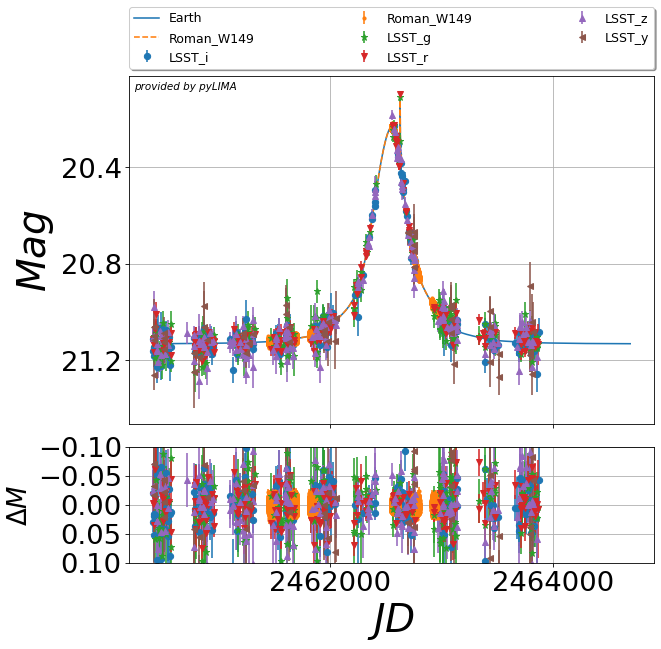

In [34]:
pyLIMA_plots.plot_lightcurves(usbl, trf2.fit_results['best_model'])

(<Figure size 750x750 with 1 Axes>, None)

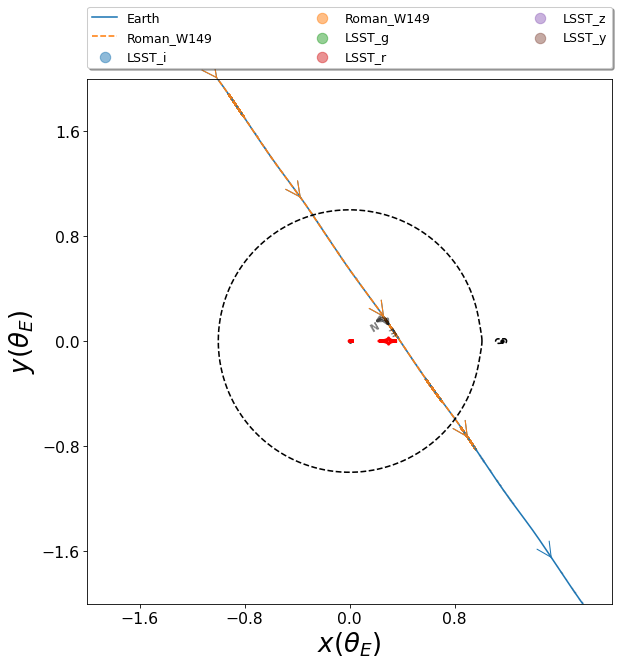

In [35]:
pyLIMA_plots.plot_geometry(usbl, trf2.fit_results['best_model'])